Welcome to my notebook! This is a copy/paste welcome message for all my notebooks :) 📓 This repository/notebook serves as a personal reminder for me, documenting code snippets and techniques sourced from various learning resources. The goal is to consolidate valuable information and create a basic reference guide. Please note that the codes included here are not originally mine, and credit goes to the respective authors and resources. Feel free to explore and use this collection as a shared learning space. Happy coding

#### Sources for this notebook : 
    * https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/tree/master/Chapter11
    
#### Purpose :
    * Convolution Autoencoders
    * VAE
    
#### Keywords :
    * VAE
    * MNIST dataset
    
    

We will just build an Variational Autoencoder model and train it on MNIST dataset. We will try to see the improvement on the predicting image quality

In [1]:

from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='.MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='.MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:04<00:00, 2316629.13it/s]


Extracting .MNIST/MNIST\raw\train-images-idx3-ubyte.gz to .MNIST/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14455333.39it/s]

Extracting .MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to .MNIST/MNIST\raw


100%|██████████| 1648877/1648877 [00:00<00:00, 4035801.90it/s]


Extracting .MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to .MNIST/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting .MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to .MNIST/MNIST\raw



In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        ## mean and std dev
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        ##decoder
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [3]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [4]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [5]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

EPOCH: 1.000  val_log_var: -0.273  train_mean: -0.000  train_loss: 2886.787  val_loss: 2343.160  train_recon: 2615.409  train_kld: 271.377  val_mean: -0.001  train_log_var: -0.163  val_recon: 1897.983  val_kld: 445.177  (12.99s - 116.92s remaining)


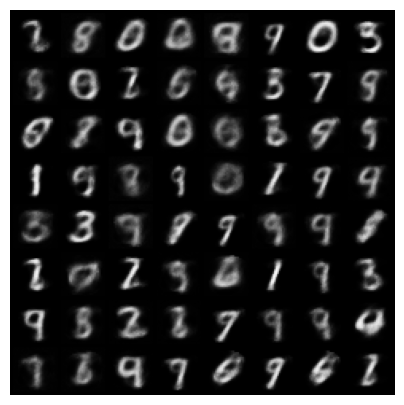

EPOCH: 2.000  val_log_var: -0.312  train_mean: -0.001  train_loss: 2214.779  val_loss: 2089.614  train_recon: 1724.947  train_kld: 489.832  val_mean: -0.009  train_log_var: -0.298  val_recon: 1577.799  val_kld: 511.815  (24.95s - 99.81s remaining)


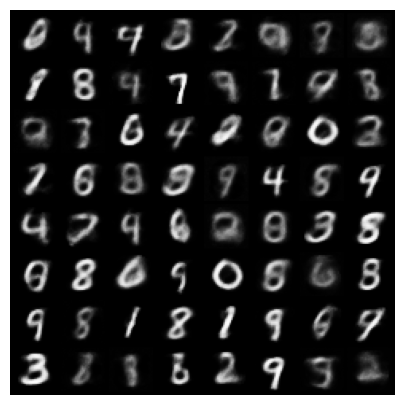

EPOCH: 3.000  val_log_var: -0.333  train_mean: -0.002  train_loss: 2067.177  val_loss: 2025.775  train_recon: 1526.322  train_kld: 540.855  val_mean: -0.005  train_log_var: -0.333  val_recon: 1476.882  val_kld: 548.893  (36.96s - 86.24s remaining)


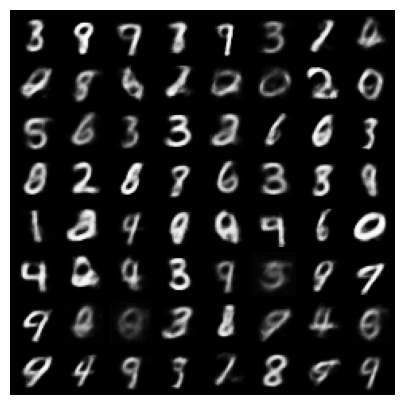

EPOCH: 4.000  val_log_var: -0.368  train_mean: -0.001  train_loss: 1996.019  val_loss: 1943.400  train_recon: 1425.984  train_kld: 570.035  val_mean: -0.003  train_log_var: -0.352  val_recon: 1351.677  val_kld: 591.723  (49.23s - 73.85s remaining)


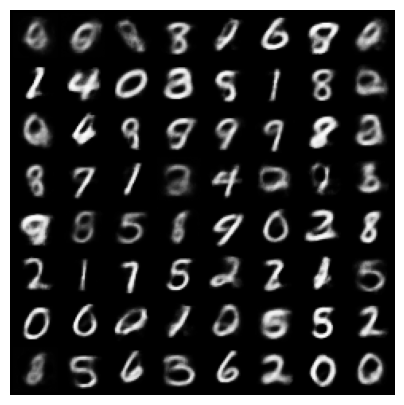

EPOCH: 5.000  val_log_var: -0.365  train_mean: -0.001  train_loss: 1948.346  val_loss: 1913.120  train_recon: 1360.447  train_kld: 587.899  val_mean: 0.002  train_log_var: -0.365  val_recon: 1326.772  val_kld: 586.349  (61.77s - 61.77s remaining)


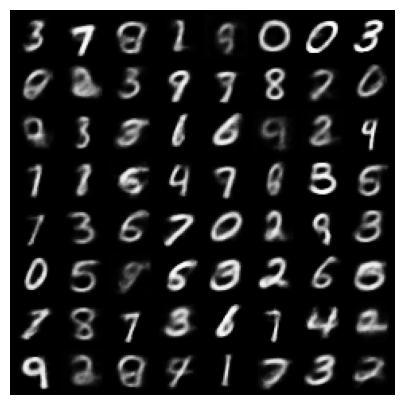

EPOCH: 6.000  val_log_var: -0.371  train_mean: -0.001  train_loss: 1921.835  val_loss: 1899.071  train_recon: 1322.237  train_kld: 599.598  val_mean: -0.006  train_log_var: -0.373  val_recon: 1305.056  val_kld: 594.015  (74.54s - 49.69s remaining)


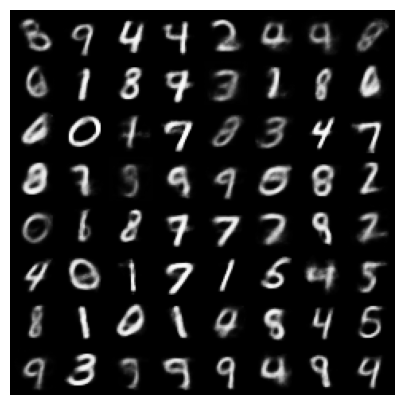

EPOCH: 7.000  val_log_var: -0.378  train_mean: -0.001  train_loss: 1900.009  val_loss: 1883.399  train_recon: 1290.661  train_kld: 609.348  val_mean: -0.006  train_log_var: -0.379  val_recon: 1284.224  val_kld: 599.174  (86.78s - 37.19s remaining)


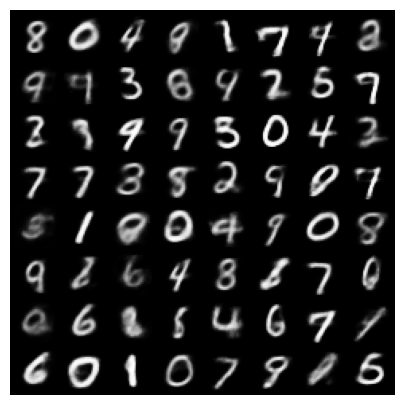

EPOCH: 8.000  val_log_var: -0.393  train_mean: -0.001  train_loss: 1881.115  val_loss: 1858.835  train_recon: 1264.952  train_kld: 616.164  val_mean: -0.003  train_log_var: -0.384  val_recon: 1228.605  val_kld: 630.230  (98.73s - 24.68s remaining)


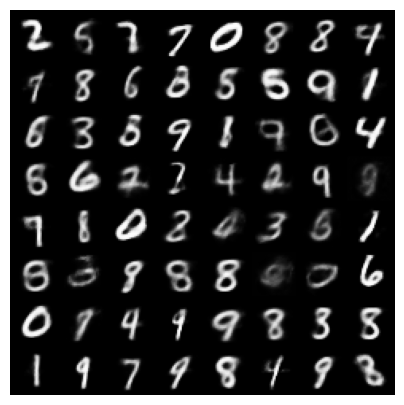

EPOCH: 9.000  val_log_var: -0.395  train_mean: -0.001  train_loss: 1865.989  val_loss: 1851.644  train_recon: 1244.029  train_kld: 621.959  val_mean: -0.001  train_log_var: -0.388  val_recon: 1223.654  val_kld: 627.991  (110.53s - 12.28s remaining)


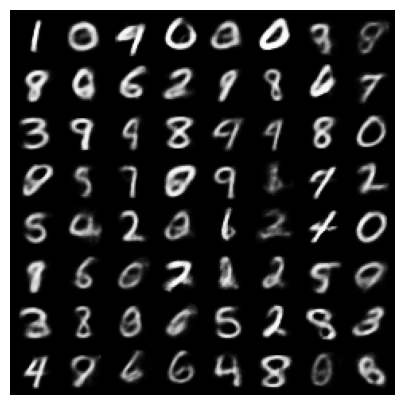

EPOCH: 10.000  val_log_var: -0.391  train_mean: -0.001  train_loss: 1855.426  val_loss: 1847.750  train_recon: 1227.609  train_kld: 627.817  val_mean: 0.001  train_log_var: -0.391  val_recon: 1223.217  val_kld: 624.534  (122.22s - 0.00s remaining)


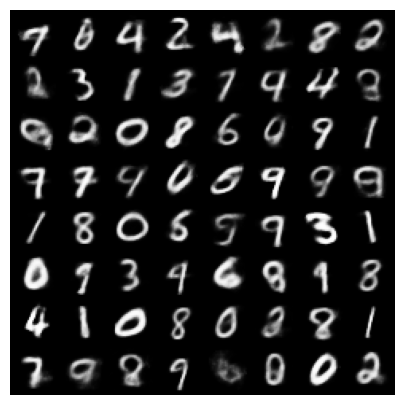

In [6]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|██████████| 111/111 [00:00<00:00, 486.38it/s]


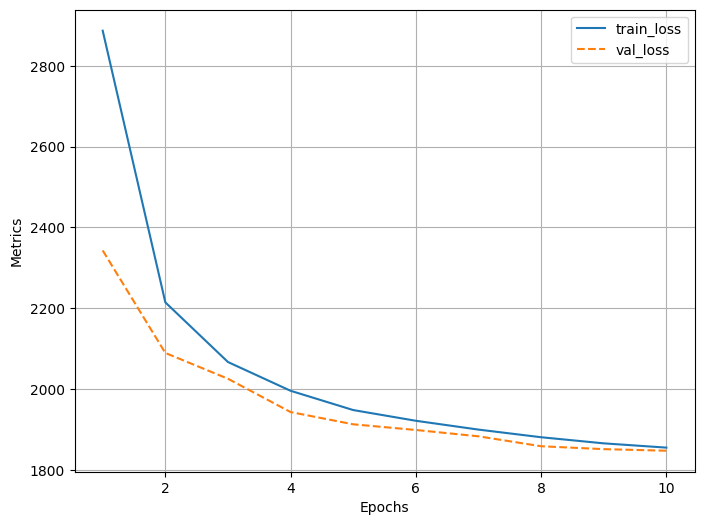

In [7]:
log.plot_epochs(['train_loss','val_loss'])

In [9]:
save_path = 'my_CNN_VAE_MNIST_10_epochs.pth'
torch.save(vae.state_dict(), save_path)